# Analysis of Voltage

In [1]:
import pandas as pd
import os
os.chdir("/home/admin123/timeseries")
fp = "ln_hpc.txt"
df = pd.read_csv(fp, sep = ";")
req_cols = ["Date", "Time", "Voltage"]
df = df[req_cols]
df["Timestamp"] = df["Date"] + " " + df["Time"]
df["Timestamp"] = pd.to_datetime(df["Timestamp"],format="%d/%m/%Y %H:%M:%S")
req_cols = ["Voltage", "Timestamp"]
df = df[req_cols]


/home/admin123/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [2]:
df_pr = df[df["Voltage"] == '?']

In [3]:
df_pr.shape

(25979, 2)

In [4]:
df_pr.dtypes

Voltage              object
Timestamp    datetime64[ns]
dtype: object

## Observation:
Frequent data errors occur. Let us aggregate at hourly intervals and see if the data quality is better. We will remove the problematic records

In [5]:
df["Voltage"] = df[- (df["Voltage"] == "?")]
df["Voltage"] = df["Voltage"].astype('float')
df = df.set_index("Timestamp")
#


In [6]:
hourly_voltage = df.groupby(pd.Grouper(freq='H')).mean()



In [7]:
df_prh = hourly_voltage[hourly_voltage["Voltage"].isnull()]

## Observation
Let us determine the number problematic data collection days in the data 

In [8]:
df_prh.loc[:,"Timestamp"] = df_prh.index.values
num_problem_days = len(df_prh["Timestamp"].dt.date.unique())

/home/admin123/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/admin123/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [9]:
num_problem_days

23

In [10]:
from fbprophet import Prophet
hourly_voltage.tail()

,Voltage
Timestamp,
2010-11-26 17:00:00,237.069667
2010-11-26 18:00:00,237.531833
2010-11-26 19:00:00,236.741000
2010-11-26 20:00:00,239.396000
2010-11-26 21:00:00,239.690000


In [11]:
m = Prophet()
hourly_voltage.loc[:, "ds"] = hourly_voltage.index.values
hourly_voltage.rename(columns = {'Voltage': 'y'}, inplace = True)
test_df = hourly_voltage.tail(72)
trng_df = hourly_voltage.head(hourly_voltage.shape[0] - 72)

In [12]:
hourly_voltage.head()

,y,ds
Timestamp,,
2006-12-16 17:00:00,234.643889,2006-12-16 17:00:00
2006-12-16 18:00:00,234.580167,2006-12-16 18:00:00
2006-12-16 19:00:00,233.232500,2006-12-16 19:00:00
2006-12-16 20:00:00,234.071500,2006-12-16 20:00:00
2006-12-16 21:00:00,237.158667,2006-12-16 21:00:00


In [13]:
m.fit(trng_df)

/home/admin123/anaconda/lib/python2.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [14]:
trng_df.shape[0]

34517

In [15]:
future_data = m.make_future_dataframe(periods=72)

In [16]:
forecast_data = m.predict(future_data)

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline 
test_df.shape[0]

72

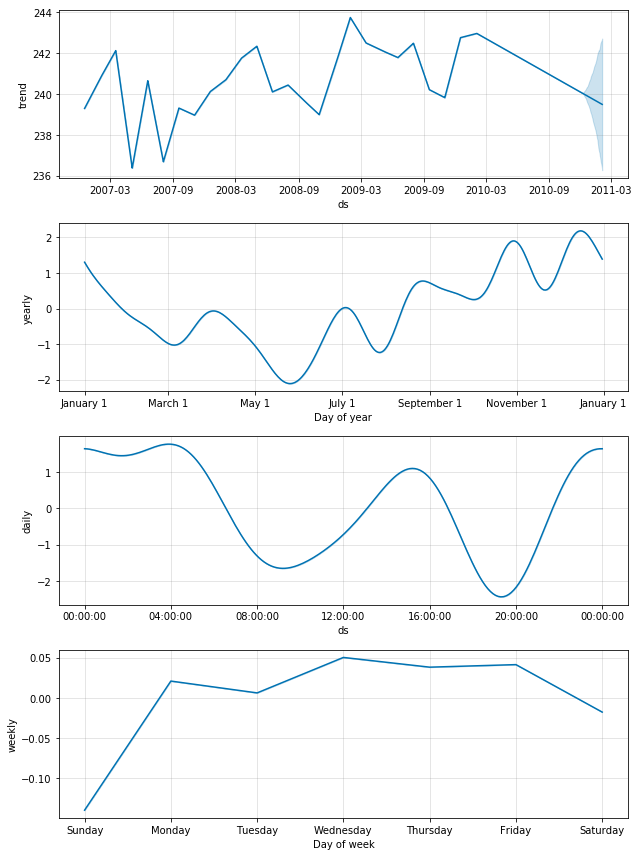

In [18]:
fig = m.plot_components(forecast_data)

In [19]:
preds = forecast_data["yhat"].tail(72)

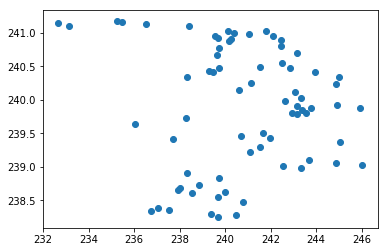

In [20]:
plt.scatter(test_df["y"], preds)

In [ ]:
err = test_df["y"].values - preds

In [ ]:
plt.hist(err)

In [ ]:
import numpy as np
np.mean(err)